# 对b站热门的七个飞盘视频进行文本分析

### 引入必须的库

In [ ]:
import imageio
import jieba
import numpy as np
import pymysql
from PIL import Image
from wordcloud import ImageColorGenerator
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

### 文本的读写
爬到的文本数据储存在一个csv文件中，下面主要是把comments列的数据提取出来，作为string储存在变量 Str 中。jieba的分词等等一般是针对 string 格式的数据。
不过这种处理的后果是无法构成时间序列数据，个人感觉之后还要做一个根据单元格分词，能进行更为深度的分析
这种处理类似于描述性统计，从宏观上把握舆论方向，可能存在一些有趣的发现

In [ ]:
Data = pd.read_csv("comment_list.CSV", encoding='gbk', header=0)
# header=0 把第一行设置为表头，encoding='gbk'可以读取中文
comments = pd.DataFrame(Data, columns=['comments'])

text = []
for row in comments.itertuples(index=False, name='comments'):
    print(row[0])
    # 这里已经可以输出纯粹的单元格内文本了，非常nice
    text.append(row[0])

Str = str(text)


### 分词和清洗

分词和清洗主要采用jieba的功能，在这里要根据爬到文本数据的特性定好 dick.txt, 在里面输入不想分开的词，需要不断的调整才能发现最优分词。

wash_as()函数输入的是一个string，输出的是一个字典，字典中包含分的词和对应的数量。

In [ ]:
def wash_as(str):
    wordlst = {}
    p1 = re.compile(r"\[.*?\]", re.S)
    list = re.findall(p1, str)
    for i in list:
        if i not in wordlst:
            wordlst[i] = 1
        else:
            wordlst[i] += 1
    for punct in wordlst.keys():
        str = str.replace(punct, ",")
    jieba.load_userdict('dict.txt')
    seglst = jieba.cut(str)
    for i in seglst:
        if i not in wordlst:
            wordlst[i] = 1
        else:
            wordlst[i] += 1
    for punct in """！？｡＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃《》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘'‛“”„‟…‧﹏.!#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~"
    """:
        if punct in wordlst:
            wordlst.pop(punct)
    poplst = []
    for char in wordlst.keys():
        if len(char) == 1:
            poplst.append(char)
    for char in poplst:
        wordlst.pop(char)
    for char in str:
        if ord(char) < 129686 and ord(char) > 127743:
            if char not in wordlst:
                wordlst[char] = 1
            else:
                wordlst[char] += 1
    return wordlst

print(wash_as(Str))

In [ ]:


# 把洗好的词放入下面的变量里面
text_washed = wash_as(Str)

### emoji分析
这里意外的发现有很多emoji被单独提了出来，因此可以引申做一个emoji使用频率分析

emoji同样采用字典形式，对字典进行排序需要用到lambda函数
rank_list 输出的是一个list，list中包含以tuple形式储存的emoji名称+频率数据


In [ ]:
emoji = {'[doge]': 367, '[呲牙]': 34, '[吃瓜]': 104, '[脱单doge]': 46, '[tv_冷漠]': 3, '[藏狐]': 58, '[脸红]': 21, '[疑惑]': 30, '[嗑瓜子]': 28, '[星星眼]': 14, '[笑哭]': 148, '[热]': 21, '[捂脸]': 37, '[妙啊]': 69, '[口罩]': 9, '[思考]': 45, '[辣眼睛]': 132, '[OK]': 34, '[滑稽]': 41, '[大哭]': 9, '[大笑]': 23, '[微笑]': 73, '[抠鼻]': 11, '[捂眼]': 7, '[哦呼]': 4, '[热词系列_知识增加]': 10, '[生气]': 7, '[点赞]': 7, '[喜极而泣]': 25, '[囧]': 11, '[鼓掌]': 6, '[歪嘴]': 11, '[惊讶]': 2, '[灵魂出窍]': 3, '[尴尬]': 3, '[傲娇]': 13, '[豹富]': 7, '[怪我咯]': 7, '[打call]': 36, '[Cat_slip]': 1, '[爱心]': 2, '[tv_抠鼻]': 1, '[无语]': 35, '[tv_呕吐]': 1, '[委屈]': 8, '[保佑]': 8, '[支持]': 11, '[原神_嗯]': 1, '[tv_doge]': 9, '[呆]': 9, '[墨镜]': 1, '[热词系列_妙啊]': 1, '[喜欢]': 12, '[tv_思考]': 3, '[tv_鼓掌]': 2, '[保卫萝卜_哭哭]': 1, '[给心心]': 53, '[尼奈_别在这发癫]': 1, '[保卫萝卜_问号]': 6, '[阴险]': 6, '[偷笑]': 22, '[跪了]': 2, '[tv_尴尬]': 1, '[Cat2_FallInto!]': 1, '[酸了]': 2, '[tv_笑哭]': 4, '[翻白眼]': 4, '[高考加油]': 5, '[热词系列_13周年]': 1, '[吐]': 10, '[嘉然2.0_擦汗]': 3, '[蛆音娘_吃瓜群众]': 1, '[干物妹！小埋_羡慕]': 1, '[原神_喝茶]': 1, '[正经人_悠闲]': 2, '[狗子]': 2, '[小电视_笑]': 1, '[tv_无奈]': 1, '[羞羞]': 1, '[热词系列_优雅]': 2, '[tv_偷笑]': 1, '[鸡腿]': 1, '[笑]': 2, '[Cat2_Inbox!]': 1, '[嫌弃]': 5, '[2233娘_大笑]': 1, '[哈欠]': 2, '[热词系列_我酸了]': 1, '[音律联觉_吃瓜]': 1, '[调皮]': 3, '[tv_目瞪口呆]': 2, '[tv_斜眼笑]': 1, '[tv_大哭]': 9, '[2233娘_委屈]': 1, '[难过]': 1, '[tv_点赞]': 3, '[来古-震撼]': 1, '[热词系列_三连]': 7, '[撇嘴]': 3, '[热词系列_锤]': 1, '[tv_流泪]': 1, '[tv_发怒]': 2, '[疼]': 1, '[星瞳_发癫]': 1, '[星瞳_扭扭]': 1, '[再见]': 1, '[热词系列_你细品]': 1, '[嘟嘟]': 3, '[来古-注意]': 1, '[向晚2.0_木头小向晚]': 1, '[奥比岛_击爪]': 1, '[tv_黑人问号]': 1, '[黑洞]': 2, '[保卫萝卜_哇]': 2, '[初音未来_nice]': 1, '[嘉然_点赞]': 1, '[Gon的旱獭_喝可乐]': 1, '[tv_白眼]': 2, '[屁股鸟_比心]': 1, '[热词系列_保护]': 1, '[伊万_不屑]': 1, '[永雏塔菲_哈哈哈]': 2, '[嘉然2.0_啊笑死]': 1, '[嘉然2.0_累了]': 1, '[蛆音娘_睡觉觉]': 1, '[星瞳_给你一拳]': 1, '[未来有你_生闷气]': 1, '[奶茶干杯]': 1, '[tv_疑问]': 1, '[热词表情_哎呦不错哦]': 2, '[tv_调侃]': 1, '[贝拉kira_sorry]': 1, '[热词系列_好活]': 1, '[Cat_coffeebath]': 1, '[永雏塔菲_嘲笑]': 2, '[热词系列_好家伙]': 1, '[拥抱]': 2, '[老鼠]': 1, '[2233塔罗牌_我觉得星]': 1, '[2233塔罗牌_不约]': 1, '[tv_亲亲]': 1, '[星瞳_跳舞]': 1, '[洛天依_吃包群众]': 1}

# def get_key (dict, value):
#     return[k for k, v in dict.items() if v == value]

rank_list = sorted(emoji.items(), key=lambda d: d[1])
print(rank_list)

dict_keys([-1.2545354, -1.2315456, -2.146456465])
['-1.2545354', '-1.2315456', '-2.146456465']


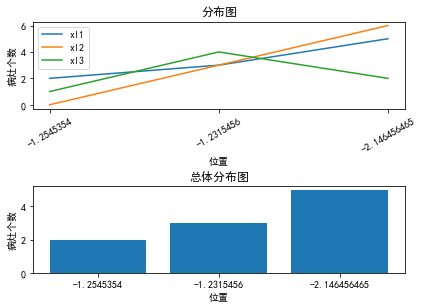

In [1]:
# 绘制词频图

import matplotlib.pyplot as plt

def plt_frequency(data=[]):
    list1 = []
    list2 = []
    for k,v in data:
        if v != 1:
            list1.append(k)
            list2.append(v)

    emoji = dict(zip(list1, list2))

    fig = plt.figure()
    plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

    x1 = list(emoji.keys())
    # x1 = list(map(str, x1))

    y1 = list(emoji.values())

    plt.bar(x1, y1)
    plt.xlabel("emoji")
    plt.ylabel('词频')

    plt.xticks(rotation=90)
    plt.title('emoji词频统计图')
    plt.show()


### 词云生成
这里函数的三个输入参数：
dict: 上面生成的字典
picture：底图（xx.jpg)，在底图上生成词云，比如放一个中国地图，他就会在中国地图上面生成词云
output：输出的文件名 (xx.png)
要注意这里的word_cloud函数自身就可以输出图像，不需要再plt.show

In [ ]:
#词云生成器
def word_cloud(dict, picture, output):
    # 蒙版图片路径
    img = imageio.imread(picture)
    w = wordcloud.WordCloud(
        background_color='white',
        mask=img,
        # max_words=300,
        # max_font_size=300,
        # min_font_size=100,
        width=2500,
        height=3000,
        font_path='STZHONGS.TTF',
        mode='RGBA',
        # random_state=1,
        prefer_horizontal=1,
    )
    w.generate_from_frequencies(dict)
    # 色彩图片路径
    color_source_image = np.array(Image.open(picture))
    colormap = ImageColorGenerator(color_source_image)
    colored_image = w.recolor(color_func=colormap)
    # 保存为图片
    colored_image.to_file(output)
    # w.generate(text)

word_cloud(emoji, 'feipan.jpg', 'emoji.png')

